# FEATURE EXTRACTION

In [23]:
# you start empty df
# loop over mt files
# create subdf that has only movement for the particular tier
# and then you calculate for this file whatever you want
# and append it to the empty df with the trialID 
import os
import glob
import pandas as pd
import numpy as np
import math
import pyentrp


#import antropy as ant
import pyentrp

from pyentrp import entropy as ent

import scipy
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import math

import xml.etree.ElementTree as ET


curfolder = os.getcwd()
print(curfolder)

mtfolder = curfolder + '/TS_movement/'
print(mtfolder)

mtfiles = glob.glob(mtfolder + '*.csv')

demographics = curfolder + "/LNDW.csv"



# create an empty dataframe where I will store all of the features.



/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/


In [24]:
# gesture space calculator: 

def gesturespace(sample, joint, side, movement_type): 
    #fileID = sample["fileID"]
    #fileID = fileID.replace('_comr.mp4', '')
    #get the subdf for where there is only arm movement. 
    total_movement = int(0)
    movement_sample = sample[sample[movement_type] == 'movement']
    if movement_sample.empty:
        return 0
    else:
        X_std = np.std(movement_sample["X_" + side + joint])
        Y_std = np.std(movement_sample["Y_" + side + joint])
        Z_std = np.std(movement_sample["Z_" + side + joint])
        total_movement = X_std + Y_std + Z_std
        return total_movement

# entropy calculator
def entrophyts(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed"]).values
        sample_entropy = ent.sample_entropy(speed_ts, 1)
        return sample_entropy

def temporal_variability_function(sample, joint, side, movement_type):
    movement_sample = sample[sample[movement_type] == "movement"]
    if movement_sample.empty:
        return 0
    else:
        speed_ts = (movement_sample[side + joint + "_speed"]).to_numpy()
        avg_height = np.mean(speed_ts)
        peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)
        if len(peaks) > 2:
            diff_in_peaks = np.empty(len(peaks)-1)
            for i in range(len(peaks)-1): 
                current_peak = sample.loc[peaks[i], "time" ]
                next_peak = sample.loc[peaks[i+1], "time" ]
                time_between_peaks = next_peak - current_peak
                diff_in_peaks[i] = time_between_peaks
            temporal_variability= np.std(diff_in_peaks)
            return temporal_variability
        else:
            return 0
    


In [25]:
# creates the dataframe of features
featuredf = pd.DataFrame()

# gets the survey information
demographics_read = pd.read_csv(demographics)

# adds survey columns to the features csv file
columns_to_add = demographics_read.columns
for col in columns_to_add:
    featuredf[col] = pd.NA


# Big For Loop For Feature Extraction

In [26]:
# big loop to loop through all of the files and extract features


count = 0
for file in mtfiles:
    print(file)
    sample = pd.read_csv(file)

    # get the fileID 
    featuredf.loc[count, "fileID"] = (sample["fileID"])[0]

    # get the chainID and the participantID
    featuredf.loc[count, "chainID"] = sample["participantID"][0]
    chainID = featuredf["chainID"][count]
    split_string = chainID.split('ch')[1]
    split_string = split_string.split('g')
    chain_num = split_string[0]
    gen_num = split_string[1]
    featuredf.loc[count, "generation_number"] = int(gen_num)
    participantID = int(chain_num) * int(gen_num)
    featuredf.loc[count, "participantID"] = participantID

    # get the demographic information from the survey and puts it in correct row in featuredf 
    matching_rows = demographics_read[demographics_read["Q1"] == str(int(participantID))]
    if len(matching_rows) >0:
        demographic_row = matching_rows.iloc[0]
        matching_row = demographics_read[demographics_read["Q1"] == str(int(participantID))]
        featuredf.loc[count, columns_to_add] = matching_row.iloc[0].values
    else:
        print("no matching demographics row")

    #Get the gesture space measures (should I move this into a function itself?)

    #left arm
    featuredf.loc[count, "left_index_movement"] = gesturespace(sample, "INDEX", "LEFT_", "arms")
    featuredf.loc[count, "left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT_", "arms")
    featuredf.loc[count, "left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT_", "arms")
    featuredf.loc[count, "total_left_arm_movement"] = featuredf.loc[count, "left_index_movement"] + featuredf.loc[count, "left_wrist_movement"] + featuredf.loc[count, "left_elbow_movement"]

    # right arm
    featuredf.loc[count, "right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT_", "arms")
    featuredf.loc[count, "right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT_", "arms")
    featuredf.loc[count, "total_right_arm_movement"] = featuredf.loc[count, "right_index_movement"] + featuredf.loc[count, "right_wrist_movement"] + featuredf.loc[count, "right_elbow_movement"]

    # left leg
    featuredf.loc[count, "left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT_", "lower_body")
    featuredf.loc[count, "left_hip_movement"] = gesturespace(sample, "HIP", "LEFT_", "lower_body")
    featuredf.loc[count, "total_left_leg_movement"] = featuredf.loc[count, "left_ankle_movement"] + featuredf.loc[count, "left_knee_movement"] + featuredf.loc[count, "left_hip_movement"]

    # right leg
    featuredf.loc[count, "right_ankle_movement"] = gesturespace(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_knee_movement"] = gesturespace(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "right_hip_movement"] = gesturespace(sample, "HIP", "RIGHT_", "lower_body")
    featuredf.loc[count, "total_right_leg_movement"] = featuredf.loc[count, "right_ankle_movement"] + featuredf.loc[count, "right_knee_movement"] + featuredf.loc[count, "right_hip_movement"]

    # head (nose)
    featuredf.loc[count, "nose_movement"] = gesturespace(sample, "NOSE", "", "head_mov")
    featuredf.loc[count, "total_head_movement"] = featuredf.loc[count, "nose_movement"]

    # total gesture space
    featuredf.loc[count, "total_gesture_space"] = featuredf.loc[count, "total_left_arm_movement"] + featuredf.loc[count, "total_right_arm_movement"] + featuredf.loc[count, "total_left_leg_movement"] + featuredf.loc[count, "total_right_leg_movement"] + featuredf.loc[count, 'total_head_movement']

    # get the entropy for wrist, knee, and ankle. 
    #wrist entropy
    featuredf.loc[count, "right_wrist_entropy"] = entrophyts(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_entropy"] = entrophyts(sample, "WRIST", "LEFT_", "arms")

    #knees enropy
    featuredf.loc[count, "right_knee_entropy"] = entrophyts(sample, "KNEE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_knee_entropy"] = entrophyts(sample, "KNEE", "LEFT_", "lower_body")

    #ankle enropy
    featuredf.loc[count, "right_ankle_entropy"] = entrophyts(sample, "ANKLE", "RIGHT_", "lower_body")
    featuredf.loc[count, "left_ankle_entropy"] = entrophyts(sample, "ANKLE", "LEFT_", "lower_body")

    #total_entropy
    featuredf.loc[count, "total_body_entropy"] = featuredf.loc[count, "left_ankle_entropy"]+ featuredf.loc[count, "right_ankle_entropy"] + featuredf.loc[count, "left_knee_entropy"] +featuredf.loc[count, "right_knee_entropy"] + featuredf.loc[count, "left_wrist_entropy"] + featuredf.loc[count, "right_wrist_entropy"]

    # temporal variability
    #wrist
    featuredf.loc[count, "right_wrist_variability"] = temporal_variability_function(sample, "WRIST", "RIGHT_", "arms")
    featuredf.loc[count, "left_wrist_variability"] = temporal_variability_function(sample, "WRIST", "LEFT_", "arms")

    #total variability
    featuredf.loc[count, 'total_body_variability'] = featuredf.loc[count, "right_wrist_variability"] + featuredf.loc[count, "left_wrist_variability"]

    count = count +1


/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch3_g12_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch2_g3_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g16_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g10_compr.eaf.csv
no matching demographics row
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g17_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g14_compr.eaf.csv
/Users/gillianrosen

/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWa

/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g12_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g3_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch2_g3_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch1_g13_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch3_g17_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/Donner_g_ch2_g6_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/kalt_g_ch2_g15_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/rennen_g_ch1_g5_compr.eaf.csv
/Users/gillianrosenberg/Documents/GitHub/FLESH_It

In [27]:
featuredf

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,right_wrist_entropy,left_wrist_entropy,right_knee_entropy,left_knee_entropy,right_ankle_entropy,left_ankle_entropy,total_body_entropy,right_wrist_variability,left_wrist_variability,total_body_variability
0,2024-06-22 20:56:58,2024-06-22 20:59:26,IP Address,80.187.86.160,100,148,True,2024-06-22 20:59:27,R_2PNn6u3joW9B5IJ,NaN,...,2.839013,2.611897,2.748509,2.648779,2.660053,2.466832,15.975083,108.937064,73.609655,182.546719
1,2024-06-22 17:29:38,2024-06-22 17:31:36,IP Address,176.3.80.248,100,118,True,2024-06-22 17:31:36,R_25HJFomSmkK8758,NaN,...,2.511356,2.427748,2.710815,2.501375,2.469158,2.461938,15.082390,481.882646,611.844540,1093.727186
2,2024-06-22 18:30:47,2024-06-22 18:32:31,IP Address,80.187.84.147,100,104,True,2024-06-22 18:32:32,R_2CBcu7cAm27UMef,NaN,...,2.405478,2.297457,2.766461,2.590594,2.693697,2.780416,15.534103,362.807979,397.086224,759.894203
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.475211,2.505289,2.639671,2.573153,2.629868,2.691879,15.515072,466.692480,376.478567,843.171046
4,2024-06-22 20:54:31,2024-06-22 20:57:15,IP Address,80.187.84.242,100,164,True,2024-06-22 20:57:15,R_8rc4FUsJ2DdEwxu,NaN,...,0.718227,0.952207,0.000000,0.000000,0.000000,0.000000,1.670434,2333.333333,1888.758165,4222.091499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2024-06-22 18:29:04,2024-06-22 18:30:21,IP Address,176.0.161.7,100,77,True,2024-06-22 18:30:22,R_20d86fCIwghMdnM,NaN,...,2.192062,2.743737,2.445596,2.657721,2.482791,2.464803,14.986711,281.519795,249.128073,530.647868
294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.901579,2.878136,2.808637,2.797363,2.772270,2.514176,16.672162,63.564173,70.965910,134.530083
295,2024-06-22 21:28:18,2024-06-22 21:29:25,IP Address,176.0.151.223,100,67,True,2024-06-22 21:29:26,R_2hVWjGGcFebSTTX,NaN,...,2.853047,2.876058,2.831902,2.770815,2.582515,2.709058,16.623394,151.634655,125.760344,277.394999
296,2024-06-22 20:56:58,2024-06-22 20:59:26,IP Address,80.187.86.160,100,148,True,2024-06-22 20:59:27,R_2PNn6u3joW9B5IJ,NaN,...,1.777126,1.797943,0.000000,0.000000,0.000000,0.000000,3.575069,41.666667,675.146075,716.812741


# code to plot the features for each participant

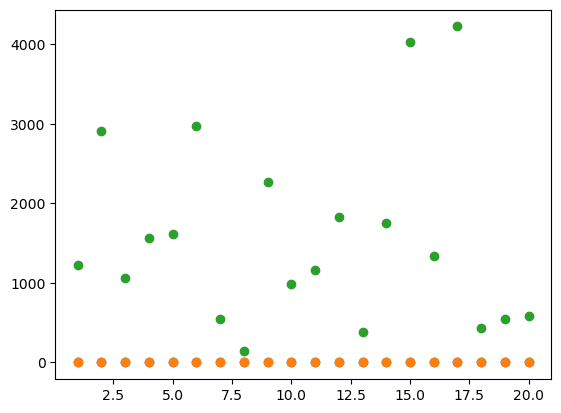

In [37]:
samplechainD = featuredf[featuredf['fileID'].str.contains("leise_g_ch2")]

plt.plot(samplechainD['generation_number'], samplechainD['total_gesture_space'], marker='o', linestyle='')
plt.plot(samplechainD['generation_number'], samplechainD['right_index_movement'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy'], marker='o', linestyle='')
#plt.plot(samplechainD['generation_number'], samplechainD['total_body_entropy'], marker='o', linestyle='')
plt.plot(samplechainD['generation_number'], samplechainD['total_body_variability'], marker='o', linestyle='')


In [79]:
samplechainD

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,nose_movement,total_head_movement,total_gesture_space,right_wrist_entropy,left_wrist_entropy,right_knee_entropy,left_knee_entropy,right_ankle_entropy,left_ankle_entropy,total_body_entropy
22,2024-06-22 18:30:47,2024-06-22 18:32:05,IP Address,176.0.161.7,100,77,True,2024-06-22 18:32:05,R_8W1NPCn1RDAdnLr,NaN,...,0.000000,0.000000,0.835723,0.660552,1.404100,NaN,NaN,NaN,NaN,NaN
28,2024-06-22 21:53:45,2024-06-22 21:55:21,IP Address,80.187.85.249,100,96,True,2024-06-22 21:55:21,R_2CHv5hlbOLlWXYv,NaN,...,0.000000,0.000000,0.828377,1.078417,2.166152,2.431657,2.393447,2.383902,2.212143,12.665718
32,2024-06-22 17:25:42,2024-06-22 17:26:47,IP Address,176.0.145.198,100,64,True,2024-06-22 17:26:47,R_80ef4T2ZilsuEGe,NaN,...,0.000000,0.000000,0.827825,1.565371,2.017794,NaN,NaN,NaN,NaN,NaN
35,2024-06-22 20:40:38,2024-06-22 20:41:50,IP Address,195.37.172.125,100,71,True,2024-06-22 20:41:50,R_2ITaokxupfNc5aE,NaN,...,0.000000,0.000000,0.619078,1.013822,1.792353,NaN,NaN,NaN,NaN,NaN
40,2024-06-22 19:02:14,2024-06-22 19:03:27,IP Address,195.37.172.125,100,73,True,2024-06-22 19:03:28,R_8oz44OCBdPW9P96,NaN,...,0.000000,0.000000,1.456957,1.908016,1.428272,NaN,NaN,NaN,NaN,NaN
43,2024-06-22 23:19:47,2024-06-22 23:20:51,IP Address,61.8.138.132,100,63,True,2024-06-22 23:20:51,R_21cxRmrbV8N6ISG,NaN,...,0.000000,0.000000,0.887340,1.306162,1.515265,NaN,NaN,NaN,NaN,NaN
46,2024-06-22 17:29:38,2024-06-22 17:31:36,IP Address,176.3.80.248,100,118,True,2024-06-22 17:31:36,R_25HJFomSmkK8758,NaN,...,0.052717,0.052717,0.988924,1.415716,1.309546,NaN,NaN,NaN,NaN,NaN
52,2024-06-22 21:29:37,2024-06-22 21:30:22,IP Address,176.0.151.223,100,45,True,2024-06-22 21:30:23,R_2hryrFFtZG5VnWe,NaN,...,0.000000,0.000000,0.901173,2.101438,1.573757,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.762359,1.014523,1.220175,NaN,NaN,NaN,NaN,NaN
99,2024-06-22 19:40:05,2024-06-22 19:44:13,IP Address,195.37.172.125,100,248,True,2024-06-22 19:44:14,R_2QJURmQ1dda9o9S,NaN,...,0.041375,0.041375,1.737943,1.376796,1.556574,NaN,NaN,NaN,NaN,NaN


# Saves the df to the feature extraction file

In [80]:
globals()["feature_extraction"] = featuredf
globals()["feature_extraction"].to_csv(os.path.join(curfolder, f'{"feature_extraction"}.csv'), index=False)

In [ ]:
sample2

# feature extraction for a single file

In [50]:
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch2_g10_compr.eaf.csv"
sample = pd.read_csv(file)
variability = temporal_variability_function(sample, "WRIST", "RIGHT_", "arms")
print(variability)

300.0
next: 
2866.666666666663
0.0


# Graphing for a single file for variability

variability: 
1125.0296040448502
[0.00063295]
variability 2: 
0.0


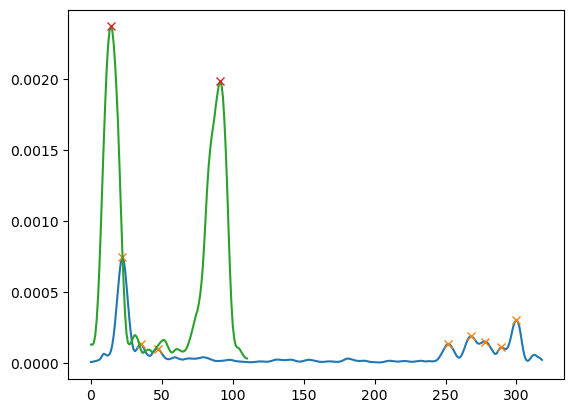

In [16]:
# graph file one
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch1_g9_compr.eaf.csv"
sample = pd.read_csv(file)
movement_sample = sample[sample['arms'] == "movement"]
speed_ts = (movement_sample["RIGHT_" + 'WRIST' + "_speed"]).to_numpy()
avg_height = np.mean(speed_ts)
peaks, _ = scipy.signal.find_peaks(speed_ts, avg_height)


plt.plot(speed_ts, label="Speed Time Series")
plt.plot(peaks, speed_ts[peaks], "x", label="Peaks")

diff_in_peaks = np.empty(len(peaks)-1)
for i in range(len(peaks)-1): 
    current_peak = sample.loc[peaks[i], "time" ]
    next_peak = sample.loc[peaks[i+1], "time" ]
    time_between_peaks = next_peak - current_peak
    diff_in_peaks[i] = time_between_peaks

variability= np.std(diff_in_peaks)
print("variability: ")
print(variability)

# graph file two
file2 = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch3_g2_compr.eaf.csv"
sample2 = pd.read_csv(file2)
movement_sample2 = sample2[sample2['arms'] == "movement"]
speed_ts2 = (movement_sample2["RIGHT_" + 'WRIST' + "_speed"]).to_numpy()
avg_height2 = np.mean(speed_ts2)
peaks2, _ = scipy.signal.find_peaks(speed_ts2, avg_height2)

plt.plot(speed_ts2, label="Speed Time Series")
plt.plot(peaks2, speed_ts2[peaks2], "x", label="Peaks")

# to calculate the total variability 
diff_in_peaks = np.empty(len(peaks2)-1)
print(diff_in_peaks)
for i in range(len(peaks2)-1): 
    current_peak = sample2.loc[peaks2[i], "time" ]
    next_peak = sample2.loc[peaks2[i+1], "time" ]
    time_between_peaks = next_peak - current_peak
    diff_in_peaks[i] = time_between_peaks

variability= np.std(diff_in_peaks)
print("variability 2: ")
print(variability)


In [ ]:
file = "/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch1_g9_compr.eaf.csv"

featuredf2 = pd.

count = 1
# get the sample
print(file)
sample = pd.read_csv(file)

# get the fileID 
featuredf.loc[count, "fileID"] = (sample["fileID"])[0]

# get the chainID and the participantID
featuredf.loc[count, "chainID"] = sample["participantID"][0]
chainID = featuredf["chainID"][count]
split_string = chainID.split('ch')[1]
split_string = split_string.split('g')
chain_num = split_string[0]
gen_num = split_string[1]
participantID = int(chain_num) * int(gen_num)
featuredf.loc[count, "participantID"] = participantID

# get the demographic information from the survey and puts it in correct row in featuredf 
matching_rows = demographics_read[demographics_read["Q1"] == str(int(participantID))]
if len(matching_rows) >0:
    demographic_row = matching_rows.iloc[0]
    matching_row = demographics_read[demographics_read["Q1"] == str(int(participantID))]
    featuredf.loc[count, columns_to_add] = matching_row.iloc[0].values
else:
    print("no matching demographics row")


# gesture space processing
#Get the gesture space measures

#left arm
featuredf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT_", "arms")
featuredf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT_", "arms")
featuredf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT_", "arms")
featuredf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]

# right arm
featuredf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT_", "arms")
featuredf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT_", "arms")
featuredf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT_", "arms")
featuredf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]

# left leg
featuredf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT_", "lower_body")
featuredf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT_", "lower_body")
featuredf["left_hip_movement"] = gesturespace(sample, "HIP", "LEFT_", "lower_body")
featuredf["total_left_leg_movement"] = featuredf["left_ankle_movement"] + featuredf["left_knee_movement"] + featuredf["left_hip_movement"]

# right leg
featuredf["right_ankle_movement"] = gesturespace(sample, "ANKLE", "RIGHT_", "lower_body")
featuredf["right_knee_movement"] = gesturespace(sample, "KNEE", "RIGHT_", "lower_body")
featuredf["right_hip_movement"] = gesturespace(sample, "HIP", "RIGHT_", "lower_body")
featuredf["total_right_leg_movement"] = featuredf["right_ankle_movement"] + featuredf["right_knee_movement"] + featuredf["right_hip_movement"]

# head (nose)
featuredf["nose_movement"] = gesturespace(sample, "NOSE", "", "head_mov")
featuredf["total_head_movement"] = featuredf["nose_movement"]

# total gesture space
featuredf["total_gesture_space"] = featuredf["total_left_arm_movement"] + featuredf["total_right_arm_movement"] + featuredf["total_left_leg_movement"] + featuredf["total_right_leg_movement"] + featuredf['total_head_movement']

# get the entrophy for wrist, knee, and ankle. 
featuredf["left_knee_entropy"] = entrophyts(sample, "KNEE", "LEFT_", 'lower_body')



'''

#left arm
featuredf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT", "arms")
featuredf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT", "arms")
featuredf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT", "arms")
featuredf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]

# right arm
featuredf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT", "arms")
featuredf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT", "arms")
featuredf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT", "arms")
featuredf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]

# left leg
featuredf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT", "lower_body")
featuredf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT", "lower_body")
featuredf["left_hip_movement"] = gesturespace(sample, "HIP", "LEFT", "lower_body")
featuredf["total_left_leg_movement"] = featuredf["left_ankle_movement"] + featuredf["left_knee_movement"] + featuredf["left_hip_movement"]
'''




/Users/gillianrosenberg/Documents/GitHub/FLESH_IteratedLearning/TS_movement/leise_g_ch1_g9_compr.eaf.csv


/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/flesh_thesis/lib/python3.12/site-packages/pyentrp/entropy.py:194: RuntimeWarning: invalid value encountered in divide
  sampen = -np.log(N_temp[1:] / N_temp[:-1])


'\n\n#left arm\nfeaturedf["left_index_movement"] = gesturespace(sample, "INDEX", "LEFT", "arms")\nfeaturedf["left_wrist_movement"] = gesturespace(sample, "WRIST", "LEFT", "arms")\nfeaturedf["left_elbow_movement"] = gesturespace(sample, "ELBOW", "LEFT", "arms")\nfeaturedf["total_left_arm_movement"] = featuredf["left_index_movement"] + featuredf["left_wrist_movement"] + featuredf["left_elbow_movement"]\n\n# right arm\nfeaturedf["right_index_movement"] = gesturespace(sample, "INDEX", "RIGHT", "arms")\nfeaturedf["right_wrist_movement"] = gesturespace(sample, "WRIST", "RIGHT", "arms")\nfeaturedf["right_elbow_movement"] = gesturespace(sample, "ELBOW", "RIGHT", "arms")\nfeaturedf["total_right_arm_movement"] = featuredf["right_index_movement"] + featuredf["right_wrist_movement"] + featuredf["right_elbow_movement"]\n\n# left leg\nfeaturedf["left_ankle_movement"] = gesturespace(sample, "ANKLE", "LEFT", "lower_body")\nfeaturedf["left_knee_movement"] = gesturespace(sample, "KNEE", "LEFT", "lower_b